## 设计基函数(basis function) 以及数据读取

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def identity_basis(x):
    ret = np.expand_dims(x, axis=1)
    return ret

def multinomial_basis(x, feature_num=10):
    x = np.expand_dims(x, axis=1) # shape(N, 1)
    feat = [x]
    for i in range(2, feature_num+1):
        feat.append(x**i)
    ret = np.concatenate(feat, axis=1)
    return ret

def gaussian_basis(x, feature_num=10):
    centers = np.linspace(0, 25, feature_num)
    width = 1.0 * (centers[1] - centers[0])
    x = np.expand_dims(x, axis=1)
    x = np.concatenate([x]*feature_num, axis=1)
    
    out = (x-centers)/width
    ret = np.exp(-0.5 * out ** 2)
    return ret

def load_data(filename, basis_func=gaussian_basis):
    """载入数据。"""
    xys = []
    with open(filename, 'r') as f:
        for line in f:
            xys.append(map(float, line.strip().split()))
        xs, ys = zip(*xys)
        xs, ys = np.asarray(xs), np.asarray(ys)
        
        o_x, o_y = xs, ys
        phi0 = np.expand_dims(np.ones_like(xs), axis=1)
        phi1 = basis_func(xs)
        xs = np.concatenate([phi0, phi1], axis=1)
        return (np.float32(xs), np.float32(ys)), (o_x, o_y)

## 定义模型

In [2]:
import tensorflow as tf
from tensorflow.keras import optimizers, layers, Model

class linearModel(Model):
    def __init__(self, ndim):
        super(linearModel, self).__init__()
        self.w = tf.Variable(
            shape=[ndim, 1], 
            initial_value=tf.random.uniform(
                [ndim,1], minval=-0.1, maxval=0.1, dtype=tf.float32))
        
    @tf.function
    def call(self, x):
        y = tf.squeeze(tf.matmul(x, self.w), axis=1)
        return y

(xs, ys), (o_x, o_y) = load_data('train.txt')        
ndim = xs.shape[1]

model = linearModel(ndim=ndim)


## 训练以及评估

In [3]:
optimizer = optimizers.Adam(0.1)
@tf.function
def train_one_step(model, xs, ys):
    with tf.GradientTape() as tape:
        y_preds = model(xs)
        loss = tf.reduce_mean(tf.sqrt(1e-12+(ys-y_preds)**2))
    grads = tape.gradient(loss, model.w)
    optimizer.apply_gradients([(grads, model.w)])
    return loss

@tf.function
def predict(model, xs):
    y_preds = model(xs)
    return y_preds

def evaluate(ys, ys_pred):
    """评估模型。"""
    std = np.sqrt(np.mean(np.abs(ys - ys_pred) ** 2))
    return std

loss is 11.76
loss is 1.658
loss is 1.611
loss is 1.575
loss is 1.536
loss is 1.498
loss is 1.457
loss is 1.414
loss is 1.37
loss is 1.323
训练集预测值与真实值的标准差：1.5
训练集预测值与真实值的标准差：1.8


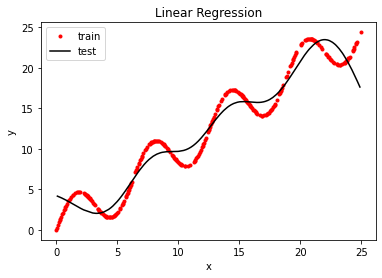

In [4]:
for i in range(1000):
    loss = train_one_step(model, xs, ys)
    if i % 100 == 1:
        print(f'loss is {loss:.4}')
        
        
y_preds = predict(model, xs)
std = evaluate(ys, y_preds)
print('训练集预测值与真实值的标准差：{:.1f}'.format(std))

(xs_test, ys_test), (o_x_test, o_y_test) = load_data('test.txt')

y_test_preds = predict(model, xs_test)
std = evaluate(ys_test, y_test_preds)
print('训练集预测值与真实值的标准差：{:.1f}'.format(std))

plt.plot(o_x, o_y, 'ro', markersize=3)
plt.plot(o_x_test, y_test_preds, 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend(['train', 'test', 'pred'])
plt.show()
